# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [321]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [342]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.weights = np.random.uniform(low=-1, high=1, size=(input_size, output_size))
        self.bias = np.zeros(output_size)

    def forward(self, x:np.ndarray)->np.ndarray:
        self.x = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, output_error_derivative:np.ndarray)->np.ndarray:
        weights_derivative = np.dot(self.x.T, output_error_derivative)
        bias_derivative = np.sum(output_error_derivative, axis=0)

        input_error_derivative = np.dot(output_error_derivative, self.weights.T)

        self.weights -= self.learning_rate * weights_derivative
        self.bias -= self.learning_rate * bias_derivative

        return input_error_derivative

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.x = x
        return np.tanh(x)

    def backward(self, output_error_derivative:np.ndarray)->np.ndarray:
        return (1 - np.tanh(self.x)**2) * output_error_derivative

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function for a particular x and y"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self._assert_layers_compatability(layers)
        self.layers = layers
        for layer in self.layers:
            layer.learning_rate = learning_rate

        self.prediction = lambda output: np.argmax(output)

    def _assert_layers_compatability(self, layers:List[Layer])->None:
        """Check if the layers are compatible"""
        linear_layers  = [layer for layer in layers if isinstance(layer, FullyConnected)]
        for i in range(len(linear_layers)-1):
            assert linear_layers[i].output_size == linear_layers[i+1].input_size, f"Layers {i} and {i+1} are not compatible"

    def compile(self, loss:Loss, prediction: callable = None)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss
        if prediction is not None:
            self.prediction = prediction

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        if x.ndim == 1:
            x = x.reshape(1, -1)
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def predict(self, output: np.ndarray) -> np.ndarray:
        """Return the result of prediciton function"""
        return self.prediction(output)
    
    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            x_test:np.ndarray=np.empty(0),
            y_test:np.ndarray=np.empty(0),
            verbose:int=0)->None:
        """Fit the network to the training data"""
        losses = []
        accuracies = []
        accuracies_test = []
        for epoch in range(epochs):
            correct  = 0
            for x, y in zip(x_train, y_train,):
                # forward
                output = self(x)
                
                loss_output = self.loss.loss(output, y)
                correct += self.predict(output) == self.predict(y)

                # backward
                loss_derivative = self.loss.loss_derivative(output, y)
                for layer in reversed(self.layers):
                    loss_derivative = layer.backward(loss_derivative)
            
            correct_test = 0
            for x, y in zip(x_test, y_test):
                output = self(x)
                correct_test += self.predict(output) == self.predict(y)

            # verbose
            accuracy = correct/len(x_train)
            accuracy_test = correct_test/len(x_test) if len(x_test) != 0 else 0
            loss_value = np.sum(loss_output)
            if verbose == 1:
                print(f"epoch {epoch+1}/{epochs} - accuracy: {accuracy:.4f}")
            elif verbose == 2:
                print(f"epoch {epoch+1}/{epochs} - accuracy: {accuracy:.4f} - loss: {loss_value:.4f}")

            losses.append(loss_value)
            accuracies.append(accuracy)
            accuracies_test.append(accuracy_test)
    
        if verbose == 3:
            # loss plot
            plt.plot(np.arange(epochs), losses)
            plt.title('Loss value over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss value (summed)')
            plt.show()

        if verbose == 4:
            # accuracy plot with train and test accuracy
            plt.plot(np.arange(epochs), accuracies, label="Train")
            plt.plot(np.arange(epochs), accuracies_test, label="Test")
            plt.title('Accuracy over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()


In [205]:
mse = Loss(lambda x, y: (x - y)**2, lambda x, y: 2*(x - y))

# Eksperymenty

### XOR

In [336]:
# setup data
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_y = np.array([[0], [1], [1], [0]])

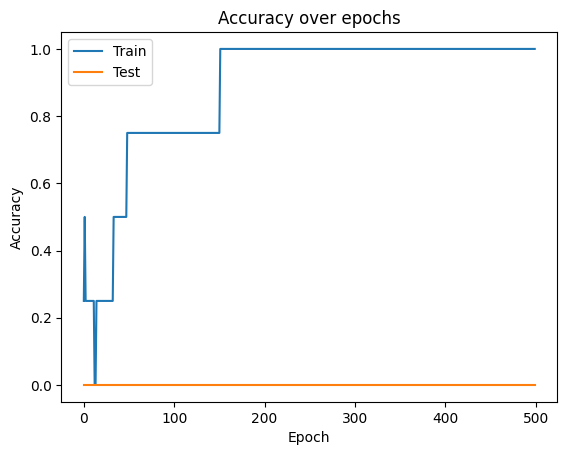

In [344]:
# XOR  network definition
xor_network = Network(
    layers=[
        FullyConnected(input_size=2, output_size=2),
        Tanh(),
        FullyConnected(input_size=2, output_size=1),
        Tanh()
    ],
    learning_rate=0.1
)

xor_network.compile(mse, lambda o: 1 if np.sum(o) >= 0.5 else 0)

# training
xor_network.fit(xor_x, xor_y, epochs=500, verbose=4)

In [345]:
# sample responses
for x_train, y_train in zip(xor_x, xor_y):
    output = xor_network(x_train)
    print(f"{x_train} -> {xor_network.predict(output)} - expected: {y_train[0]}")

[0 0] -> 0 - expected: 0
[0 1] -> 1 - expected: 1
[1 0] -> 1 - expected: 1
[1 1] -> 0 - expected: 0


### MNIST (small)

In [346]:
def visualise(network: Network, x: np.ndarray, y:np.ndarray, samples:int = 9, size = 28):
    sample_indices = np.random.choice(len(x), samples, replace=False)
    sample_images = x[sample_indices]
    sample_labels = np.argmax(y[sample_indices], axis=1)

    predictions = [network.predict(network(sample_image)) for sample_image in sample_images]

    sample_images = sample_images.reshape(samples, size, size)

    # Plot the sample images and their predicted labels
    fig, axes = plt.subplots(1, samples, figsize=(samples*2, 2))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i], cmap='gray')
        ax.set_title(f"P: {predictions[i]} T: {sample_labels[i]}", color=('black' if predictions[i] == sample_labels[i] else 'red'))
        ax.axis('off')
    plt.show()

In [347]:
def load_smalll_digits(random_state=42):
    # setup data
    small_digits = load_digits()

    x = small_digits.data / 16
    y = np.zeros((len(x), 10))

    for i, value in enumerate(y):
        value[small_digits.target[i]] = 1

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return x_train, x_test, y_train, y_test

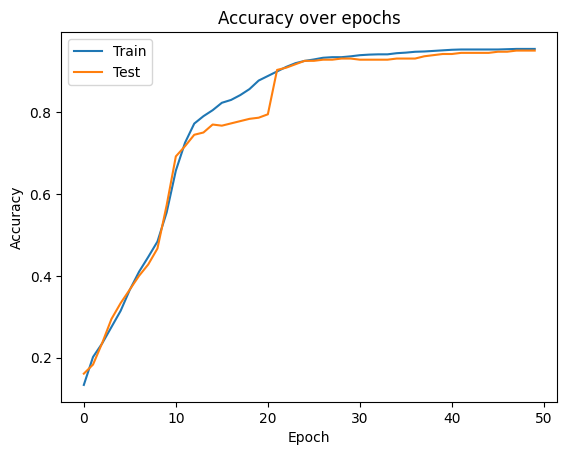

In [349]:
x_train, x_test, y_train, y_test = load_smalll_digits()

small_network = Network([
    FullyConnected(64, 16), Tanh(), 
    FullyConnected(16, 10), Tanh()
    ], 0.01)

small_network.compile(mse)

small_network.fit(x_train, y_train, epochs=50, verbose=4, x_test=x_test, y_test=y_test)

In [309]:
for state in [1,2,3]:
    x_train, x_test, y_train, y_test = load_smalll_digits(state)

    small_network = Network([
        FullyConnected(64, 16), Tanh(), 
        FullyConnected(16, 10), Tanh()
        ], 0.01)

    small_network.compile(mse)

    small_network.fit(x_train, y_train, epochs=50, verbose=0)

    correct = np.sum([small_network.predict(small_network(x)) == small_network.predict(y) for x, y in zip(x_test, y_test)])
    print(f"With state {state}, accuracy on test set: {correct/len(x_test):.4f}")

With state 1, accuracy on test set: 0.8806
With state 2, accuracy on test set: 0.9056
With state 3, accuracy on test set: 0.7694


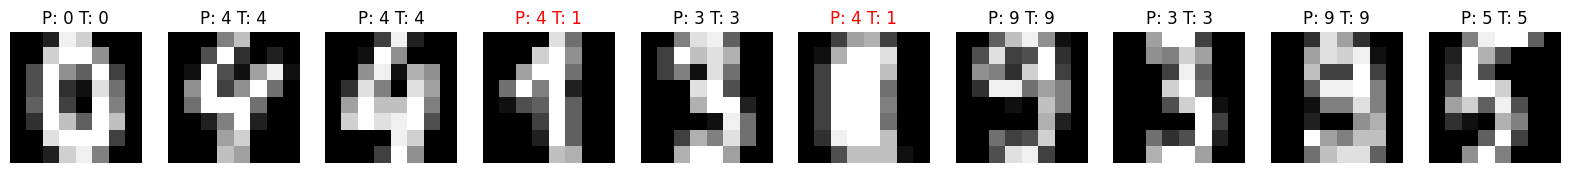

In [313]:
visualise(small_network, x_test, y_test, samples=10, size=8)

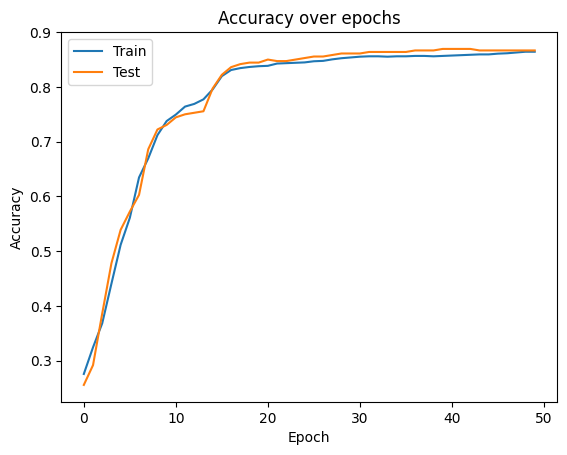

With state 1, 1 hidden-layer with 10 neurons, accuracy on test set: 0.8694
With state 2, 1 hidden-layer with 10 neurons, accuracy on test set: 0.8417
With state 3, 1 hidden-layer with 10 neurons, accuracy on test set: 0.7806


In [350]:
x_train, x_test, y_train, y_test = load_smalll_digits()

small_network = Network([
    FullyConnected(64, 10), Tanh(), 
    FullyConnected(10, 10), Tanh()
    ], 0.01)

small_network.compile(mse)

small_network.fit(x_train, y_train, epochs=50, verbose=4, x_test=x_test, y_test=y_test)

for state in [1,2,3]:
    x_train, x_test, y_train, y_test = load_smalll_digits()

    small_network = Network([
        FullyConnected(64, 10), Tanh(), 
        FullyConnected(10, 10), Tanh()
        ], 0.01)

    small_network.compile(mse)

    small_network.fit(x_train, y_train, epochs=50, verbose=0)

    correct = np.sum([small_network.predict(small_network(x)) == small_network.predict(y) for x, y in zip(x_test, y_test)])
    print(f"With state {state}, 1 hidden-layer with 10 neurons, accuracy on test set: {correct/len(x_test):.4f}")

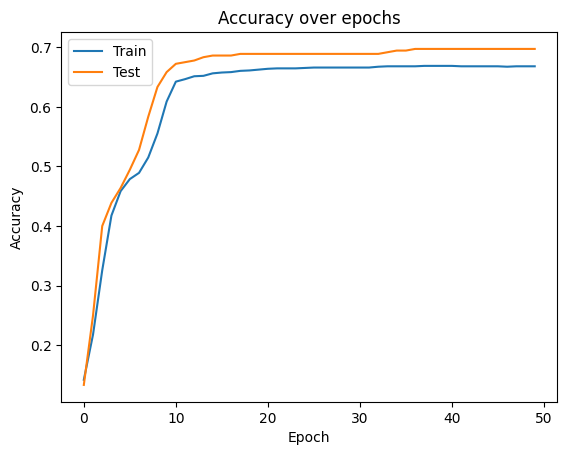

In [361]:
x_train, x_test, y_train, y_test = load_smalll_digits()

small_network = Network([
    FullyConnected(64, 8), Tanh(), 
    FullyConnected(8, 10), Tanh()
    ], 0.01)

small_network.compile(mse)

small_network.fit(x_train, y_train, epochs=50, verbose=4, x_test=x_test, y_test=y_test)

# for state in [1,2,3]:
#     x_train, x_test, y_train, y_test = load_smalll_digits(state)

#     small_network = Network([
#         FullyConnected(64, 256), Tanh(), 
#         FullyConnected(256, 10), Tanh()
#         ], 0.01)

#     small_network.compile(mse)

#     small_network.fit(x_train, y_train, epochs=50, verbose=0)

#     correct = np.sum([small_network.predict(small_network(x)) == small_network.predict(y) for x, y in zip(x_test, y_test)])
#     print(f"With state {state}, with 1 hidden-layer 256 neurons, accuracy on test set: {correct/len(x_test):.4f}")

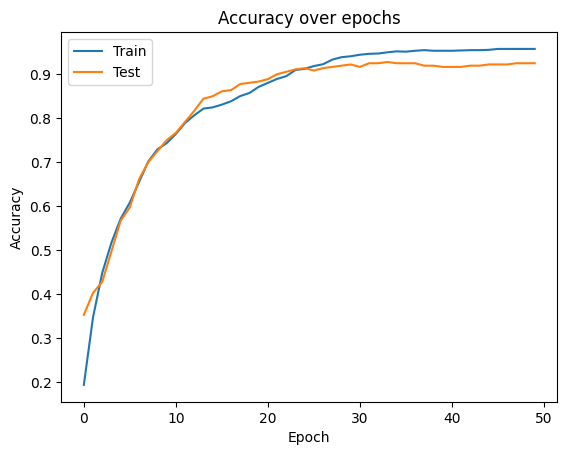

With state 1, with 2 hidden-layers 10 neurons, accuracy on test set: 0.8444
With state 2, with 2 hidden-layers 10 neurons, accuracy on test set: 0.7472
With state 3, with 2 hidden-layers 10 neurons, accuracy on test set: 0.8528


In [354]:
x_train, x_test, y_train, y_test = load_smalll_digits()

small_network = Network([
    FullyConnected(64, 10), Tanh(), 
    FullyConnected(10, 10), Tanh(),
    FullyConnected(10, 10), Tanh()
    ], 0.01)

small_network.compile(mse)

small_network.fit(x_train, y_train, epochs=50, verbose=4, x_test=x_test, y_test=y_test)

for state in [1,2,3]:
    x_train, x_test, y_train, y_test = load_smalll_digits(state)

    small_network = Network([
        FullyConnected(64, 10), Tanh(), 
        FullyConnected(10, 10), Tanh(),
        FullyConnected(10, 10), Tanh()
        ], 0.01)

    small_network.compile(mse)

    small_network.fit(x_train, y_train, epochs=50, verbose=0)

    correct = np.sum([small_network.predict(small_network(x)) == small_network.predict(y) for x, y in zip(x_test, y_test)])
    print(f"With state {state}, with 2 hidden-layers 10 neurons, accuracy on test set: {correct/len(x_test):.4f}")

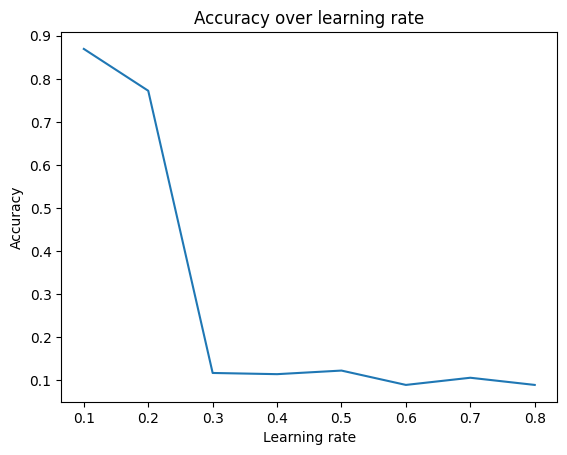

In [299]:
# learning rate impact on accuracy

learning_rates = np.arange(0.1, 0.9, 0.1)
accuracies = []
for lr in learning_rates:
    small_network = Network([
        FullyConnected(64, 10), Tanh(), 
        FullyConnected(10, 10), Tanh()
        ], lr)

    small_network.compile(mse)

    small_network.fit(x_train, y_train, epochs=50, verbose=0)

    correct = np.sum([small_network.predict(small_network(x)) == small_network.predict(y) for x, y in zip(x_test, y_test)])
    accuracies.append(correct/len(x_test))

plt.plot(learning_rates, accuracies)
plt.title('Accuracy over learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show()


### MNIST (normal)

In [322]:
def load_normal_digits(random_state=42):
    digits = fetch_openml('mnist_784', version=1, parser='auto')
    x = digits.data.to_numpy() / 255
    y = np.zeros((len(x), 10))
    for i, value in enumerate(y):
        value[int(digits.target.to_numpy()[i])] = 1

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    return x_train, x_test, y_train, y_test

In [324]:
x_train, x_test, y_train, y_test = load_normal_digits()

network = Network([
    FullyConnected(784, 16), Tanh(), 
    FullyConnected(16, 16), Tanh(),
    FullyConnected(16, 10), Tanh()
    ], 0.01)

network.compile(mse)

network.fit(x_train, y_train, epochs=50, verbose=2)

correct = np.sum([network.predict(network(x)) == network.predict(y) for x, y in zip(x_test, y_test)])
print(f"Accuracy on test set: {correct/len(x_test)*100:.2f}%")


epoch 1/50 - accuracy: 0.4773 - loss: 0.3975
epoch 2/50 - accuracy: 0.6717 - loss: 0.0953
epoch 3/50 - accuracy: 0.7602 - loss: 0.0802
epoch 4/50 - accuracy: 0.7900 - loss: 0.0747
epoch 5/50 - accuracy: 0.8031 - loss: 0.0726
epoch 6/50 - accuracy: 0.8117 - loss: 0.0729
epoch 7/50 - accuracy: 0.8170 - loss: 0.0684
epoch 8/50 - accuracy: 0.8224 - loss: 0.0718
epoch 9/50 - accuracy: 0.8287 - loss: 0.0668
epoch 10/50 - accuracy: 0.8933 - loss: 0.0567
epoch 11/50 - accuracy: 0.9127 - loss: 0.0556
epoch 12/50 - accuracy: 0.9153 - loss: 0.0545
epoch 13/50 - accuracy: 0.9175 - loss: 0.0540
epoch 14/50 - accuracy: 0.9195 - loss: 0.0545
epoch 15/50 - accuracy: 0.9215 - loss: 0.0462
epoch 16/50 - accuracy: 0.9227 - loss: 0.0505
epoch 17/50 - accuracy: 0.9229 - loss: 0.0566
epoch 18/50 - accuracy: 0.9239 - loss: 0.0551
epoch 19/50 - accuracy: 0.9252 - loss: 0.0555
epoch 20/50 - accuracy: 0.9258 - loss: 0.0526
epoch 21/50 - accuracy: 0.9258 - loss: 0.0320
epoch 22/50 - accuracy: 0.9279 - loss: 0.01

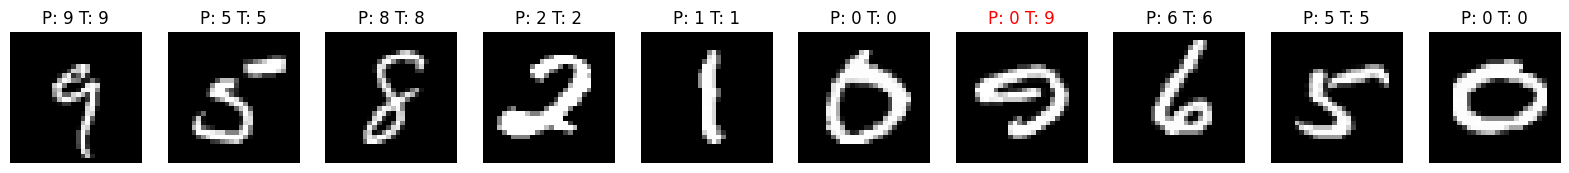

In [327]:
visualise(network, x_test, y_test, samples=10, size=28)


# Wnioski

- architektura sieci jest rzeczą kluczową ale nie ma jednej najlepszej, dla naszego problemu architektura wielowarstwowa zwykle działała gorzej (równiez architektura wieloneuronowa)
- dla MNISTa zwykle wystarczyło 1-2 warstwy ukryte
- learning rate przy zbyt dużym kroku może powodować oscylacje, przy zbyt małym uczenie może trwać bardzo długo
- zbyt duża liczba epok może powodować overfitting
- zbyt mała liczba epok może powodować underfitting
- zbyt duza liczba neuronów może powodować overfitting
- dla wiekszych datasetów (np. normalny MNIST) uczenie pełne trwa zbyt długo, dlatego lepiej używać mini-batchy